In [358]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
np.set_printoptions(suppress=True)
from tqdm import tqdm
from sklearn.neighbors import KernelDensity

import cv2

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid')
np.set_printoptions(suppress=True)


In [25]:
count = 0

filelist = []
focal_ids = []
with open("tracks_id.txt") as fp:
    Lines = fp.readlines()[1:]
    for line in Lines:
        count += 1
        values = line.split("\t")
        filelist.append(values[0].strip().replace("_TR",""))
        focal_ids.append([int(x) for x in values[1].strip().split(",")])
        

In [26]:
data_dir =  '/home/staff1/ctorney/data/cochno_ponies/'


In [200]:
def acorr(series):
    n = len(series)
    data = np.asarray(series)
    
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / n

    def r(h):
        return ((data[: n - h] - mean) * (data[h:] - mean)).sum() / n / c0

    x = np.arange(n) + 1
    y = [r(loc) for loc in x]
    
    return x,y

77.81196617128899
74.47554324470184
77.94920782533427
74.65721251203922
65.75969741038534
73.85773582134834
74.6935841748068
94.86106338358218
75.51010246861074
70.29924480314912
66.29971752516587
70.96656255143807
66.49084375968869
63.661068846289254
62.09935500716256
56.16624913269038
68.21202109954902
74.95478618703373
71.736572265625
64.1886607325082
67.8251953125
50.260427527853835
71.79418634793137


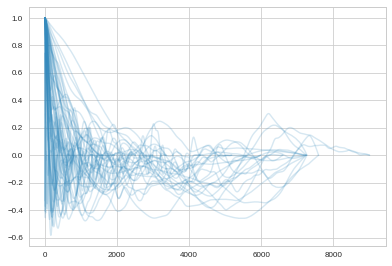

In [336]:

focal_locations = np.zeros((2,0))
body_lengths = np.zeros((1,0))

acorlengths = []
nonfocal_locations = np.zeros((2,0))
nonf_body_lengths = np.zeros((1,0))

for input_file, focal_id in zip(filelist,focal_ids):
    
    direct, ext = os.path.split(input_file)
    noext, _ = os.path.splitext(ext)
    data_file = data_dir + '/tracks/' +  noext + '_POS.txt'
    
    tracks = np.genfromtxt(data_file,delimiter=",",dtype='float')
    
    ## remove any short tracks or low proportion
    alltrackids = np.unique(tracks[:,1])

    for t in alltrackids:
        thisTrack = tracks[tracks[:,1]==t]
        #print(len(thisTrack))
        if len(thisTrack)<10:
            tracks = tracks[tracks[:,1]!=t]
            continue
        frame_len = thisTrack[-1,0]-thisTrack[0,0]+1
        fraction_present = len(thisTrack)/frame_len
        if fraction_present<0.6:
            tracks = tracks[tracks[:,1]!=t]
        continue
        
    max_len_fid = 0
    for fid in focal_id:
        thisTrack = tracks[tracks[:,1]==fid]
        if len(thisTrack)==0:
            continue
        max_lens = max(np.max(thisTrack[:,4]-thisTrack[:,2]),np.max(thisTrack[:,5]-thisTrack[:,3]))
        if max_lens>max_len_fid:
            max_len_fid = max_lens
        body_lengths = np.hstack([body_lengths,np.full(shape=(1,thisTrack.shape[0]),fill_value=max_len_fid)])
        trackCentres = np.array([0.5*(thisTrack[:,2]+thisTrack[:,4]),0.5*(thisTrack[:,3]+thisTrack[:,5])])
        x,y = acorr(trackCentres[0])
        acorlengths.append(np.where(np.array(y)<0.5)[0][0])
        plt.plot(x,y, c='C1',alpha=0.2)
        x,y = acorr(trackCentres[1])
        acorlengths.append(np.where(np.array(y)<0.5)[0][0])
        plt.plot(x,y, c='C1',alpha=0.2)
        focal_locations = np.hstack([focal_locations,trackCentres])
    
    print(max_len_fid)

    for t in alltrackids:
        if t in focal_id: 
            continue
        thisTrack = tracks[tracks[:,1]==t]
        nonf_body_lengths = np.hstack([nonf_body_lengths,np.full(shape=(1,thisTrack.shape[0]),fill_value=max_len_fid)])
        trackCentres = np.array([0.5*(thisTrack[:,2]+thisTrack[:,4]),0.5*(thisTrack[:,3]+thisTrack[:,5])])
        nonfocal_locations = np.hstack([nonfocal_locations,trackCentres])
            
image_centre = np.array([[3840./2],[2160./2]])
xydist = nonfocal_locations-image_centre
dists = (xydist[0]**2 + xydist[1]**2)**0.5
dists = dists/nonf_body_lengths[0]

# average distance of non-focal individuals to the centre
plt1_av_dist_nf = np.mean(dists)

xydist = focal_locations-image_centre
dists = (xydist[0]**2 + xydist[1]**2)**0.5
dists = dists/body_lengths[0]



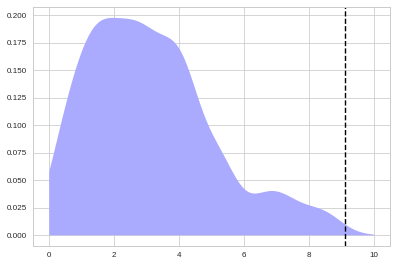

In [338]:
X = dists[:,None]#:np.percentile(np.array(acorlengths),99,method='closest_observation'),None]
plt1_X = np.linspace(0, 10, 100)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(X)
plt1_Y = np.exp(kde.score_samples(plt1_X[:, np.newaxis]))
plt.fill_between(plt1_X, plt1_Y, fc="#AAAAFF")
plt.axvline(av_dist_nf,ls='--',color='k')
plt.show()

#### Nearest neighbour distances

100%|██████████| 7245/7245 [00:04<00:00, 1592.85it/s]


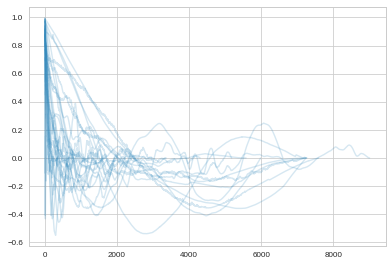

In [308]:

focal_locations = np.zeros((2,0))
body_lengths = np.zeros((1,0))


nn_distances = np.zeros((0,3))

acorlengths = []
nonfocal_locations = np.zeros((2,0))
nonf_body_lengths = np.zeros((1,0))

for input_file, focal_id in zip(filelist,focal_ids):
    
    direct, ext = os.path.split(input_file)
    noext, _ = os.path.splitext(ext)
    data_file = data_dir + '/tracks/' +  noext + '_POS.txt'
    
    tracks = np.genfromtxt(data_file,delimiter=",",dtype='float')
    
    ## remove any short tracks or low proportion
    alltrackids = np.unique(tracks[:,1])

    for t in alltrackids:
        thisTrack = tracks[tracks[:,1]==t]
        #print(len(thisTrack))
        if len(thisTrack)<10:
            tracks = tracks[tracks[:,1]!=t]
            continue
        frame_len = thisTrack[-1,0]-thisTrack[0,0]+1
        fraction_present = len(thisTrack)/frame_len
        if fraction_present<0.6:
            tracks = tracks[tracks[:,1]!=t]
        continue
        
    max_len_fid = 0
    for fid in focal_id:
        thisTrack = tracks[tracks[:,1]==fid]
        if len(thisTrack)==0:
            continue
        
        
        times = thisTrack[:,0]
        fcentres = np.array([0.5*(thisTrack[:,2]+thisTrack[:,4]),0.5*(thisTrack[:,3]+thisTrack[:,5])])
        
        nn_distance = np.zeros((times.shape[0],3))
        for i in tqdm(range(times.shape[0])):
            t = times[i]
            fcentre = fcentres[:,thisTrack[:,0]==t]

            ntracks = tracks[tracks[:,0]==t]
            ntracks = ntracks[ntracks[:,1]!=fid]
            ncentres = np.array([0.5*(ntracks[:,2]+ntracks[:,4]),0.5*(ntracks[:,3]+ntracks[:,5])])
            ndists = np.sort(np.linalg.norm(fcentre-ncentres,axis=0))[:3]
            if ndists.shape[0]==3:
                nn_distance[i] = ndists
            
            
        #neighbours = 
        max_lens = max(np.max(thisTrack[:,4]-thisTrack[:,2]),np.max(thisTrack[:,5]-thisTrack[:,3]))
        if max_lens>max_len_fid:
            max_len_fid = max_lens
        body_lengths = np.hstack([body_lengths,np.full(shape=(1,thisTrack.shape[0]),fill_value=max_len_fid)])
        trackCentres = np.array([0.5*(thisTrack[:,2]+thisTrack[:,4]),0.5*(thisTrack[:,3]+thisTrack[:,5])])
        nn_distances = np.vstack([nn_distances,nn_distance])
        x,y = acorr(nn_distance[:,0])
        acorlengths.append(np.where(np.array(y)<0.5)[0][0])
        plt.plot(x,y, c='C1',alpha=0.2)
        

    
            



In [312]:
nn_distances = nn_distances/body_lengths.T

In [314]:
nn_distances = nn_distances[nn_distances[:,0]>0]

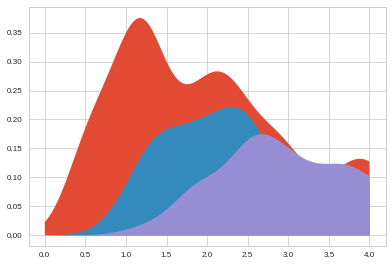

In [333]:

plt2_X = np.linspace(0, 4, 100)

X = nn_distances[:,0,None]#np.percentile(np.array(acorlengths),20,method='closest_observation'),0,None]
kde = KernelDensity(kernel="gaussian", bandwidth=0.25).fit(X)
plt2_Ynn1 = np.exp(kde.score_samples(plt2_X[:, np.newaxis]))
X = nn_distances[:,1,None]#[::np.percentile(np.array(acorlengths),20,method='closest_observation'),1,None]
kde = KernelDensity(kernel="gaussian", bandwidth=0.25).fit(X)
plt2_Ynn2 = np.exp(kde.score_samples(plt2_X[:, np.newaxis]))

X = nn_distances[:,2,None]#[::np.percentile(np.array(acorlengths),20,method='closest_observation'),2,None]
kde = KernelDensity(kernel="gaussian", bandwidth=0.25).fit(X)
plt2_Ynn3 = np.exp(kde.score_samples(plt2_X[:, np.newaxis]))




plt.show()

In [380]:
im = cv2.imread('yolo_predictions.jpg')

(left, right, bottom, top) = (1650,2450,700,1250)
im = im[bottom:top,left:right,::-1]
#im = im[:,:,::-1]



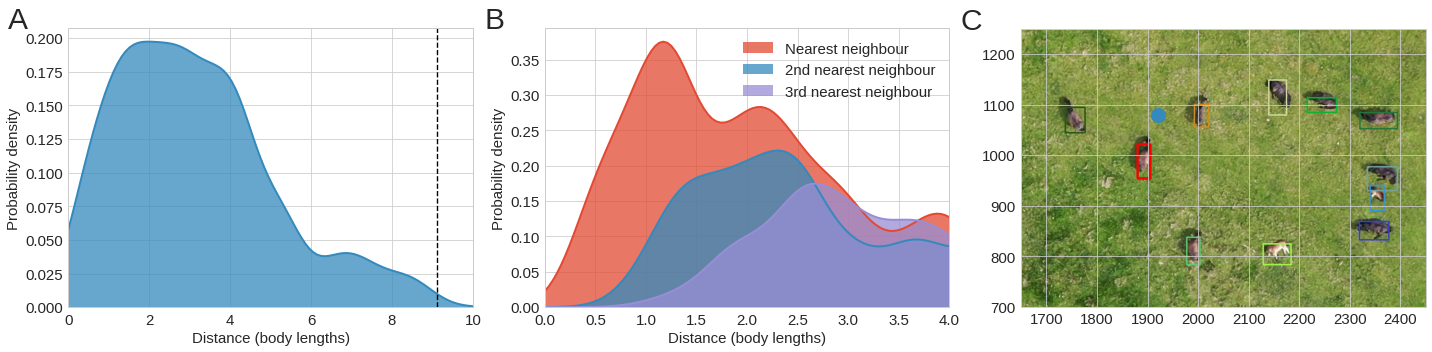

In [390]:
#fig, axs = plt.subplots(2, 3, figsize=(40,20))#,gridspec_kw={'width_ratios': [1,1,1]})
fig, axs = plt.subplots(1, 3, figsize=(20,5))#,gridspec_kw={'width_ratios': [1,1,1.5]})

# ax0 = axs[0, 0].contourf(xx,yy,var_grid,levels=100,cmap='viridis',vmin=0.05,vmax=0.18)

axs[0].plot(plt1_X, plt1_Y, c="C1",lw=2)
axs[0].fill_between(plt1_X, plt1_Y, fc="C1",alpha=0.75)
axs[0].axvline(av_dist_nf,ls='--',color='k')
axs[0].set_ylim(0,None)
axs[0].set_xlim(0,10)

axs[0].set_xlabel('Distance (body lengths)',size=15)
axs[0].set_ylabel('Probability density',size=15)
axs[0].text(-0.15,1,'A', size=30, transform=axs[0].transAxes)
axs[0].tick_params(axis='both', which='major', labelsize=15)


axs[1].plot(plt2_X, plt2_Ynn1, c="C0",lw=2)
axs[1].fill_between(plt2_X, plt2_Ynn1, fc="C0",alpha=0.75, label='Nearest neighbour')
axs[1].plot(plt2_X, plt2_Ynn2, c="C1",lw=2)
axs[1].fill_between(plt2_X, plt2_Ynn2, fc="C1",alpha=0.75, label='2nd nearest neighbour')
axs[1].plot(plt2_X, plt2_Ynn3, c="C2",lw=2)
axs[1].fill_between(plt2_X, plt2_Ynn3, fc="C2",alpha=0.75, label='3rd nearest neighbour')

axs[1].legend(fontsize=15)

axs[1].set_ylim(0,None)
axs[1].set_xlim(0,4)

axs[1].set_xlabel('Distance (body lengths)',size=15)
axs[1].set_ylabel('Probability density',size=15)
axs[1].text(-0.15,1,'B', size=30, transform=axs[1].transAxes)
axs[1].tick_params(axis='both', which='major', labelsize=15)



axs[2].imshow(im,extent=(left, right, bottom, top),origin='lower')
axs[2].plot(image_centre[0],image_centre[1],'o',c='C1',markersize=15)
axs[2].tick_params(axis='both', which='major', labelsize=15)
axs[2].text(-0.15,1, 'C', size=30, transform=axs[2].transAxes)

fig.tight_layout()


plt.savefig("case_study.png",dpi=600)
plt.show()








In [288]:
aa = 
bb=np.sort(aa)
print(aa,bb[:3])

[139.70903787 152.8683029  206.22210764] [139.70903787 152.8683029  206.22210764]


In [162]:
print(tracks.shape)
alltrackids = np.unique(tracks[:,1])

for t in alltrackids:
    thisTrack = tracks[tracks[:,1]==t]
    #print(len(thisTrack))
    if len(thisTrack)<10:
        tracks = tracks[tracks[:,1]!=t]
        continue
    frame_len = thisTrack[-1,0]-thisTrack[0,0]+1
    fraction_present = len(thisTrack)/frame_len
    if fraction_present<0.8:
        tracks = tracks[tracks[:,1]!=t]
        continue
    
print(tracks.shape)


(75648, 6)
(69800, 6)


In [175]:
tracks = np.genfromtxt(data_file,delimiter=",",dtype='float')

print(len(tracks[tracks[:,1]==fid]))

thisTrack = tracks[tracks[:,1]==fid]
thisTrack[-1,0]-thisTrack[0,0]+1

8


9.0

In [75]:

# image_centre = np.array([[2160./2],[3840./2]])

In [76]:
image_centre.shape

(2, 1)

In [93]:

#,thisTrack[:,5]-thisTrack[:,3])
np.full(shape=(1,thisTrack.shape[0]),fill_value=2.)

(1, 7183)

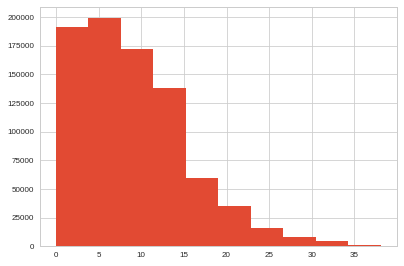

In [231]:

plt.hist(dists,bins=10)
plt.show()

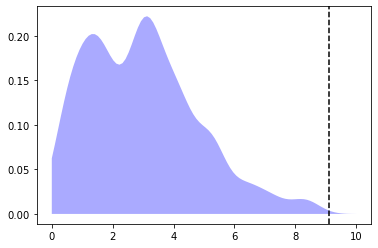

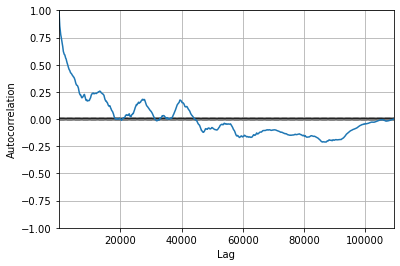

(array([-7000, -6999, -6998, ...,  6998,  6999,  7000]),
 array([0.02387805, 0.02400866, 0.02413924, ..., 0.02413924, 0.02400866,
        0.02387805]),
 <matplotlib.lines.Line2D at 0x7fe670d70070>)

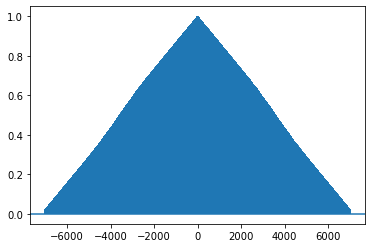

In [190]:
dists

In [121]:
dists[::1000].shape

(110,)

In [45]:
np.array([0.5*(thisTrack[:,2]+thisTrack[:,4]),0.5*(thisTrack[:,3]+thisTrack[:,5])]).shape

(2, 7245)

In [47]:
aa = np.zeros((2,0))

In [51]:
np.hstack([aa,np.array([0.5*(thisTrack[:,2]+thisTrack[:,4]),0.5*(thisTrack[:,3]+thisTrack[:,5])])])

(2, 7245)

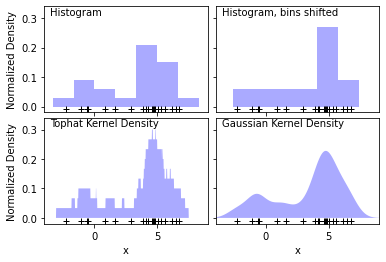

In [104]:
np.random.seed(1)
N = 20
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc="#AAAAFF", density=True)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc="#AAAAFF", density=True)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel="tophat", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), "+k")
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel("Normalized Density")

for axi in ax[1, :]:
    axi.set_xlabel("x")

In [105]:
X

array([[ 1.62434536],
       [-0.61175641],
       [-0.52817175],
       [-1.07296862],
       [ 0.86540763],
       [-2.3015387 ],
       [ 6.74481176],
       [ 4.2387931 ],
       [ 5.3190391 ],
       [ 4.75062962],
       [ 6.46210794],
       [ 2.93985929],
       [ 4.6775828 ],
       [ 4.61594565],
       [ 6.13376944],
       [ 3.90010873],
       [ 4.82757179],
       [ 4.12214158],
       [ 5.04221375],
       [ 5.58281521]])